# HW 1-1: Deep vs. Shallow
### Adam Patyk
### CPSC 8430

## Part 1: Simulate a function

In [1]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

### Create models and validate number of parameters
# hyperparameters
epochs = 20000
input_size = 1
output_size = 1
shallow_hidden_size = 303
mod_hidden_sizes = [9, 46]
deep_hidden_size = 10

# Model 0
class ShallowNetwork(nn.Module):
    def __init__(self):
        super(ShallowNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, shallow_hidden_size),
            nn.ReLU(),
            nn.Linear(shallow_hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

# Model 1
class ModerateNetwork(nn.Module):
    def __init__(self):
        super(ModerateNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, mod_hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(mod_hidden_sizes[0], mod_hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(mod_hidden_sizes[1], mod_hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(mod_hidden_sizes[0], output_size),
        )

    def forward(self, x):
        return self.model(x)

# Model 2
class DeepNetwork(nn.Module):
    def __init__(self):
        super(DeepNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, deep_hidden_size),
            nn.ReLU(),
            nn.Linear(deep_hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

models = []
models.append(ShallowNetwork())
models.append(ModerateNetwork())
models.append(DeepNetwork())

for i in range(len(models)):
    num_params = sum(p.numel() for p in models[i].parameters())
    print(f'Model {i} parameters: {num_params}')
    

Model 0 parameters: 910
Model 1 parameters: 911
Model 2 parameters: 911


In [2]:
### Create data for training

# Dataset for function data (e^x * sin^2(3*pi*x))
class FunctionDataset(Dataset):
    def __init__(self, size, start, end):
        data = np.zeros((size, 2))
        data[:, 0] = np.arange(start, end, 1/size)
        data[:, 1] = np.exp(data[:, 0]) * np.sin(3 * math.pi * data[:, 0]) ** 2
        data = torch.from_numpy(data).float()
        self.x = data
        self.mean = torch.mean(data)
        self.stddev = torch.std(data)
    
    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return len(self.x)

    def __mean__(self):
        return self.mean

    def __stddev__(self):
        return self.stddev

    def standardize(self):
        data = (self.x - self.mean) / self.stddev

        return data

# create 100 data points from function e^x * sin^2(3*pi*x) [0, 1]
data = FunctionDataset(100, 0, 1)

# z-score standardize training data
training_data = data.standardize()

# create data loader for batch training
training_loader = DataLoader(training_data, batch_size=1, shuffle=True)

print('Data ready.')

Data ready.


In [3]:
### Train models (skip section if models already trained) [est. time: ~2 hours]

def train(model, data_loader, epochs):
    optimizer = optim.Adam(model.parameters())  # use adaptive learning rate over stochastic gradient descent
    loss_func = nn.MSELoss()                    # use mean-squared error loss function
    model.zero_grad()
    training_loss = []

    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for datum in data_loader:
            input, target = datum[0][0].reshape(-1), datum[0][1].reshape(-1)
            optimizer.zero_grad()
            output = model(input)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(data_loader)
        training_loss.append(epoch_loss)
        if epoch % 1000 == 999: # print every 1000 epochs
            print(f'Epoch: {epoch+1}/{epochs} \tLoss: {epoch_loss:.6f}', flush=True)
    
    total_time = (time.time() - start_time)
    print(f'Training time: {total_time//60:.0f} min {total_time%60:.2f} s')

    return training_loss

training_loss = []

for i in range(len(models)):
    print(f'Training model {i}:')
    loss_arr = train(models[i], training_loader, epochs)
    training_loss.append(loss_arr)
    torch.save(models[i], f'func_models/model{i}.pt')
    
np.savetxt('training_loss.txt', np.array(training_loss))

Training model 0:
Epoch: 10/20000 	Loss: 1.238137
Epoch: 20/20000 	Loss: 1.149303
Epoch: 30/20000 	Loss: 1.054277
Epoch: 40/20000 	Loss: 0.913949
Epoch: 50/20000 	Loss: 0.849348
Epoch: 60/20000 	Loss: 0.771306
Epoch: 70/20000 	Loss: 0.678461
Epoch: 80/20000 	Loss: 0.579116
Epoch: 90/20000 	Loss: 0.520828


KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


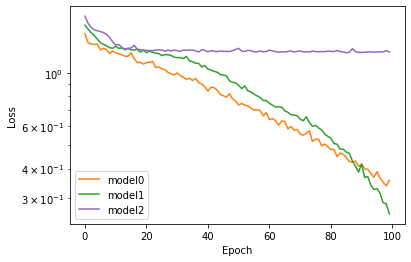

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


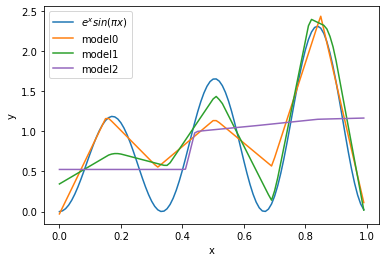

In [6]:
### Plot results
def inverse_standardize(data, mean, stddev):
    data = data * stddev + mean
    return data

# load data from previous training
models = []
models.append(torch.load('func_models/model0.pt'))
models.append(torch.load('func_models/model1.pt'))
models.append(torch.load('func_models/model2.pt'))

training_loss = np.loadtxt('training_loss.txt')

colors = ['tab:orange', 'tab:green', 'tab:purple']

# plot loss over epochs
for i in range(len(models)):
    plt.plot(np.arange(0, epochs), training_loss[i], color=colors[i], label=f'model{i}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig('loss_comparison.eps')
plt.show()

# plot values from final model
plt.plot(data[:, 0], data[:, 1], label=r'$e^xsin(\pi x)$')
for i in range(len(models)):
    func_vals = []
    for datum in training_data:
        input = datum[0].reshape(-1)
        output = models[i](input)
        output = inverse_standardize(output, data.mean, data.stddev)
        func_vals.append(output)
    plt.plot(data[:, 0], func_vals, color=colors[i],label=f'model{i}')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.savefig('output_comparison.eps')
plt.show()

## Part 2: Train on MNIST

In [24]:

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

### Create models
epochs = 10

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

class ShallowCNN(CNNModel):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.model(x)

models = []
models.append(ShallowCNN())
#models.append(ModerateCNN())
#models.append(DeepCNN())

### Load data
training_set = torchvision.datasets.MNIST(root='./data/', train=True, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64,
                                          shuffle=True, num_workers=2)

testing_set = torchvision.datasets.MNIST(root='./data/', train=False, download=True)
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=64,
                                         shuffle=False, num_workers=2)


In [26]:
### Train models (skip section if models already trained) [est. time: TBD hours]

def train(model, data_loader, epochs):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # stochastic gradient descent
    loss_func = nn.CrossEntropyLoss()   # Cross entropy loss function
    model.zero_grad()

    start_time = time.time()
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, (data, target) in enumerate(data_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(data_loader)
        training_loss.append(epoch_loss)
        #if epoch % 10 == 9: # print every 10 epochs
        print(f'Epoch: {epoch+1}/{epochs} \tLoss: {epoch_loss:.6f}', flush=True)

    total_time = (time.time() - start_time)
    print(f'Training time: {total_time//60:.0f} min {total_time%60:.2f} s')
    
    return training_loss

training_loss = []

for i in range(len(models)):
    print(f'Training model {i}:')
    loss_arr = train(models[i], training_loader, epochs)
    training_loss.append(loss_arr)
    torch.save(models[i], f'mnist_models/model{i}.pt')


Training model 0:


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/amp/opt/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/amp/opt/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/Users/amp/opt/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 83, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/Users/amp/opt/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 83, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/Users/amp/opt/miniconda3/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 85, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [ ]:
def test(model, data_loader):
    model.eval()
    testing_loss = 0.0
    correct = 0
    TP = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            testing_loss += loss.item()
            if output == target:
                TP += 1
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == target).sum().item()
    num_data = len(data_loader.dataset)
    print(total)
    print(num_data)
    print(TP)
    print(correct)
    testing_loss /= num_data
    testing_acc = TP / num_data * 100
    print(f'Accuracy: {TP}/{num_data} ({testing_acc:.2f})\tLoss: {epoch_loss:.6f}', flush=True)

testing_loss = []

for i in range(len(models)):
    print(f'Testing model {i}:')
    loss_arr = test(models[i], testing_loader)
    testing_loss.append(loss_arr)